In [177]:
#library building
import networkx as nx
import math
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import combinations as comb
#constants
SEED= 42

In [178]:
#**** Graph building helper functions ****#

#degree k, rewiring probability p
def get_watts_strogatz_graph(nodeNum,k,p):   
    G = nx.watts_strogatz_graph(nodeNum,k,p,seed=SEED)
    for e in G.edges():
        G[e[0]][e[1]]['weight'] = 1
    return G

# Build g
def get_undirected_ER_graph(nodeNum, p):
    G = nx.erdos_renyi_graph(nodeNum,p,seed=SEED)
    for e in G.edges():
        G[e[0]][e[1]]['weight'] = 1
    return G

#Generate tree with powerlaw degree distribution
def get_powerlaw_tree_graph(nodeNum,gamma):
    G = nx.random_powerlaw_tree(nodeNum,gamma,seed=SEED)
    for e in G.edges():
        G[e[0]][e[1]]['weight'] = 1
    return G


In [197]:
#Graph helper functions

def draw_graph_helper(H,positionFlag="spring"):
    
    if (positionFlag.startswith("spring")):
        pos=nx.spring_layout(H,iterations=20)
    if (positionFlag.startswith("random")):
        pos=nx.random_layout(H)
    plt.figure(figsize=(10,10))
    
    nx.draw_networkx_nodes(H,pos)
    nx.draw_networkx_edges(H,pos)
    nx.draw_networkx_labels(H,pos,fontsize=12)
    
    labels = nx.get_edge_attributes(H,'weight')
    labelsNonZero = {}
    for l in labels.keys():
        if labels[l] > 0.0001:
            labelsNonZero[l] = labels[l]
            
    
    nx.draw_networkx_edge_labels(H,pos,edge_labels=labelsNonZero)
    
    plt.show()
    return

Watts Strogatz Ring (no rewiring)


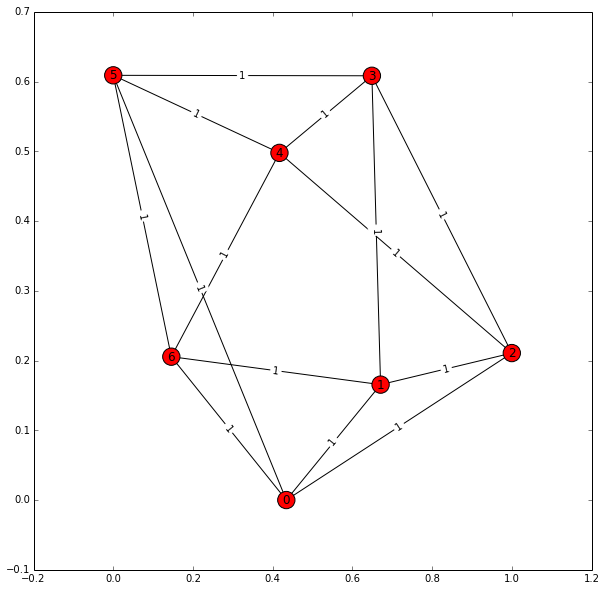

ER graph, p=0.3


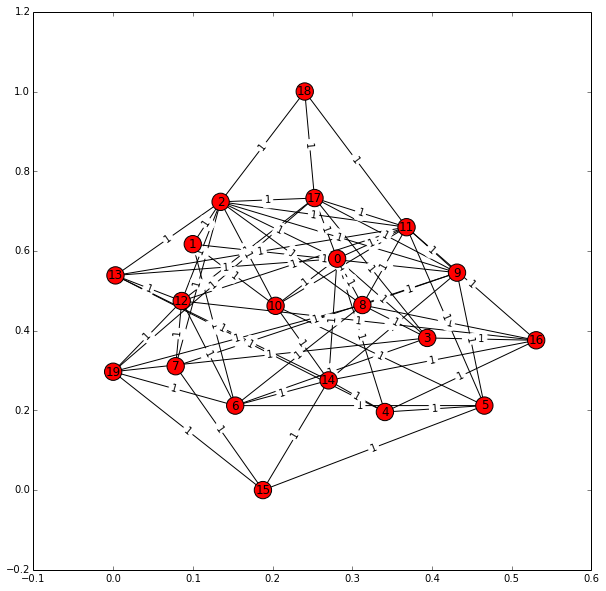

Powerlaw tree, gamma= 3


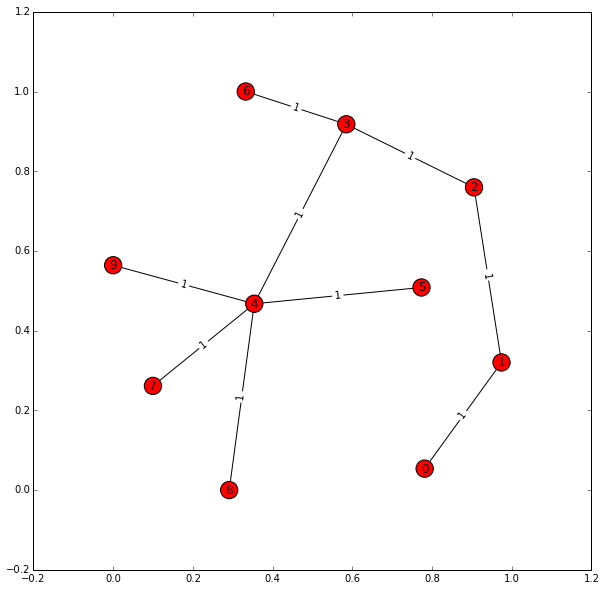

In [180]:
#Quick test of all graph generators
print "Watts Strogatz Ring (no rewiring)"
WS1 = get_watts_strogatz_graph(7,4,0.0)
draw_graph_helper(WS1,"spring")
print "ER graph, p=0.3"
draw_graph_helper(get_undirected_ER_graph(20,0.3),"spring")
print "Powerlaw tree, gamma= 3"
PLTREE1 = get_powerlaw_tree_graph(10,3)
draw_graph_helper(PLTREE1,"spring")



In [181]:
#Construct a graph whose edge weights are the likelihood of an awareness relationship, given the contact graph G
#under the JS spline metric model
# --> This is a symetric measure
def construct_awareness_from_contact_graph(G):
    H = G.copy()
    #print "Edges",H.edges()
    for pair in comb(G.nodes(),2): #get pairs
        x = pair[0]
        y = pair[1]
       
        metric = 0.0
        if (y in G[x].keys()):#if y a neighor of x (and visa versa)
            metric = 0.5
            
        #JS Metric
        xNbr = set(G[x])
        yNbr = set(G[y])
        mutualNbrs = xNbr.intersection(yNbr)
        
        metric = metric + len(mutualNbrs)/float(len(xNbr.union(yNbr)))
        
        #set as edge weight in new graph
        if (y not in H[x]):
            H.add_edge(x,y)
        H[x][y]['weight'] = metric
        
    return H
        
    

In [218]:
#Calculate the expected number of neighbors of S in nodeSet, not including S itself
def get_exp_coverage(G,nodeSet,S):
    #Coverage probabilities of
    #print "Finding coverage of S = ",S
    covg = {}
    
    for n in S:
        #Get neighbors
        for b in G[n]:
            #If not in nodeSet or in S, ignore
            if (b not in nodeSet or b in S):
                continue
            #If in nodeSet and already covered by some node, update coverage
            elif (b in covg.keys()): 
                #Update coverage of b
                covg[b] = 1 - (1-covg[b])*(1-G[n][b]['weight'])
            else:
                covg[b] = G[n][b]['weight']
                
    #return the sum of all of the coverage weights
    return sum([covg[x] for x in covg.keys()])
    
# Find approximation max coverage set using k-greedy method, with t total nodes in solution
def greedy_expected_max_coverage_set(G,t,k):
    #Debug
    assert(t < len(G.nodes()))
    
        #solution
    soln = set()
           
    #node set
    remaining_nodes = set(G.nodes())
    
    #Construct how many nodes to select at each step
    k_vals = [k for _ in range(int(math.floor(float(t)/k)))]
    if (t - sum(k_vals) > 0):
        k_vals.append(t - sum(k_vals))
    #Debug
    assert(sum(k_vals) == t)
    
    for sub_k in k_vals:
        
        #Get value of current (partial solution)
        if (len(soln) > 0):
            current_covg = get_exp_coverage(G,G.nodes(),soln)
        else:
           current_covg = 0.0
           
        max_sym_diff = 0.0
        best_seen_soln = set()
        remaining_nodes = remaining_nodes.difference(soln)
        
        print "\n Selecting next ", sub_k, "nodes from set ", remaining_nodes
        for nodeset in comb(remaining_nodes,sub_k): #For all k combinations of unselected nodes
            #calculate expected coverage with the addition of nodeset to the current solution
            sym_diff = get_exp_coverage(G,G.nodes(),soln.union(nodeset))
            print "Coverage of ", soln.union(nodeset), "is ", sym_diff
            if (sym_diff > max_sym_diff):
                print "Using ", nodeset, "as current best"
                max_sym_diff = sym_diff
                best_seen_soln = nodeset
        print "Chose node(s) ", list(best_seen_soln)
        #Add found nodes to solution set
        #Debug
        assert(len(set(best_seen_soln).intersection(soln)) == 0)
        soln = soln.union(set(best_seen_soln))
    return soln

Power law tree awareness graph


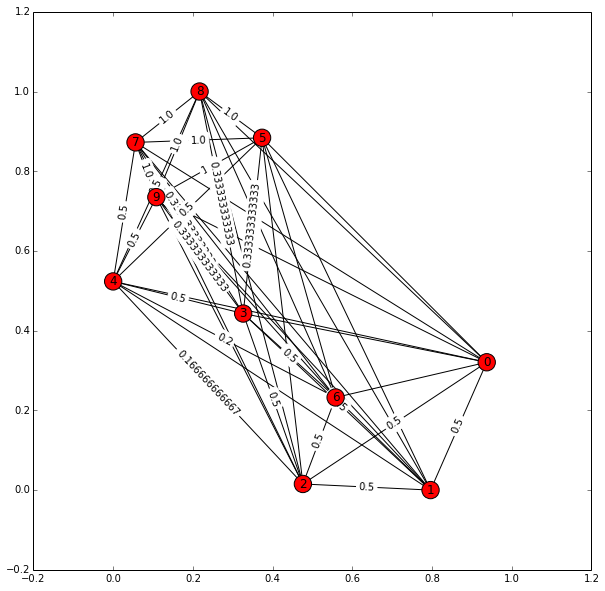

Watts strogatz (no rewire) awareness graph


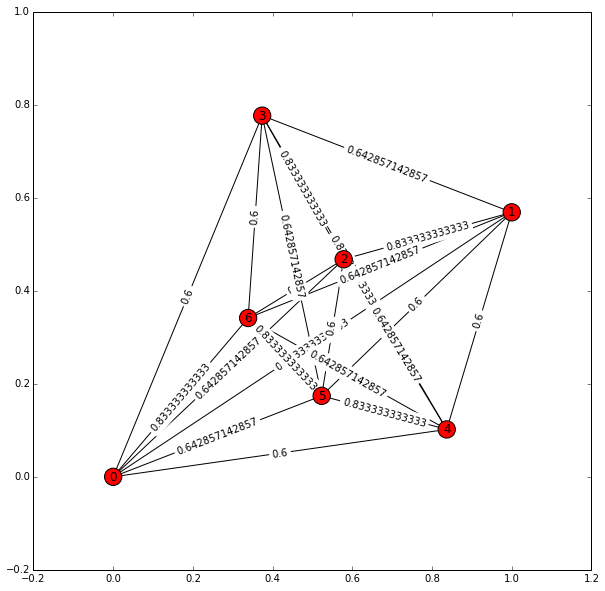

In [219]:
#sanity test of coverage max algorithm
PLTREE1_AWARENESS = construct_awareness_from_contact_graph(PLTREE1)
print "Power law tree awareness graph"
draw_graph_helper(PLTREE1_AWARENESS)

print "Watts strogatz (no rewire) awareness graph"
WS1_AWARENESS = construct_awareness_from_contact_graph(WS1)
draw_graph_helper(WS1_AWARENESS)



 Selecting next  1 nodes from set  set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Coverage of  set([0]) is  1.0
Using  (0,) as current best
Coverage of  set([1]) is  1.25
Using  (1,) as current best
Coverage of  set([2]) is  2.16666666667
Using  (2,) as current best
Coverage of  set([3]) is  3.08333333333
Using  (3,) as current best
Coverage of  set([4]) is  2.86666666667
Coverage of  set([5]) is  3.83333333333
Using  (5,) as current best
Coverage of  set([6]) is  1.2
Coverage of  set([7]) is  3.83333333333
Coverage of  set([8]) is  3.83333333333
Coverage of  set([9]) is  3.83333333333
Chose node(s)  [5]
One node soln set([5])

 Selecting next  1 nodes from set  set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Coverage of  set([0]) is  1.0
Using  (0,) as current best
Coverage of  set([1]) is  1.25
Using  (1,) as current best
Coverage of  set([2]) is  2.16666666667
Using  (2,) as current best
Coverage of  set([3]) is  3.08333333333
Using  (3,) as current best
Coverage of  set([4]) is  2.86666666667
Coverage o

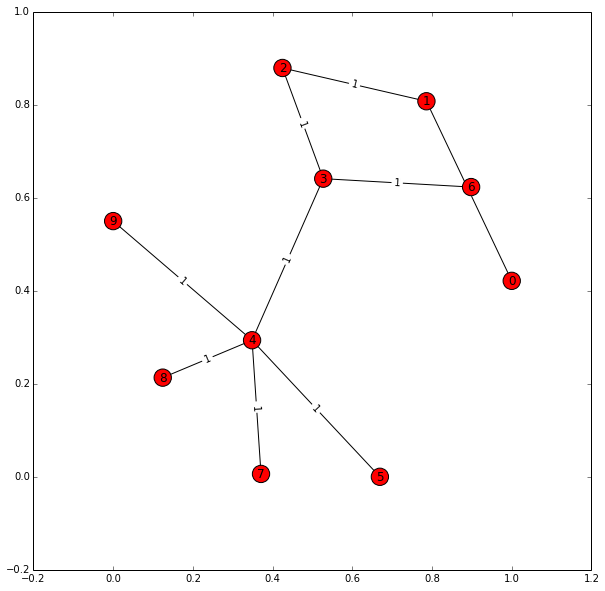

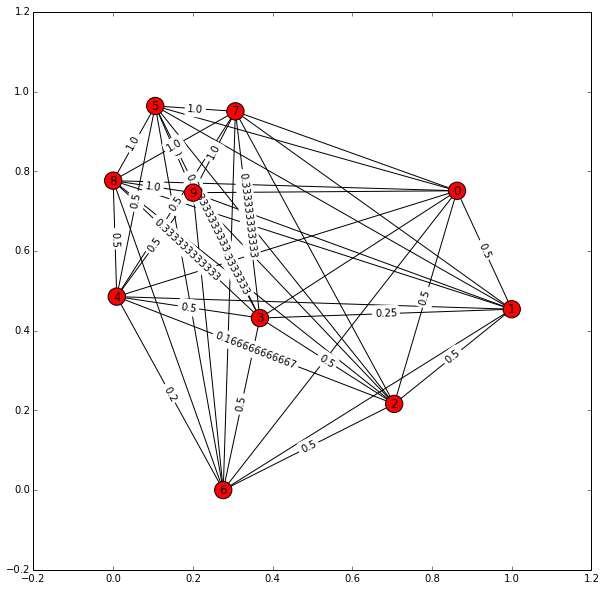

In [220]:
S1 = greedy_expected_max_coverage_set(PLTREE1_AWARENESS,1,1)
print "One node soln",S1

S2 = greedy_expected_max_coverage_set(PLTREE1_AWARENESS,2,1)
print "Two node soln, greedy",S2

S3 = greedy_expected_max_coverage_set(PLTREE1_AWARENESS,2,1)
print "Two node soln, opt", S3

draw_graph_helper(PLTREE1,"spring")

draw_graph_helper(PLTREE1_AWARENESS,"spring")





 Selecting next  1 nodes from set  set([0, 1, 2, 3, 4, 5, 6])
Coverage of  set([0]) is  4
Using  (0,) as current best
Coverage of  set([1]) is  4
Coverage of  set([2]) is  4
Coverage of  set([3]) is  4
Coverage of  set([4]) is  4
Coverage of  set([5]) is  4
Coverage of  set([6]) is  4
Chose node(s)  [0]

 Selecting next  1 nodes from set  set([1, 2, 3, 4, 5, 6])
Coverage of  set([0, 1]) is  4
Using  (1,) as current best
Coverage of  set([0, 2]) is  5
Using  (2,) as current best
Coverage of  set([0, 3]) is  5
Coverage of  set([0, 4]) is  5
Coverage of  set([0, 5]) is  5
Coverage of  set([0, 6]) is  4
Chose node(s)  [2]
Two node soln to watts strogatz contact greedy set([0, 2])

 Selecting next  2 nodes from set  set([0, 1, 2, 3, 4, 5, 6])
Coverage of  set([0, 1]) is  4
Using  (0, 1) as current best
Coverage of  set([0, 2]) is  5
Using  (0, 2) as current best
Coverage of  set([0, 3]) is  5
Coverage of  set([0, 4]) is  5
Coverage of  set([0, 5]) is  5
Coverage of  set([0, 6]) is  4
Cover

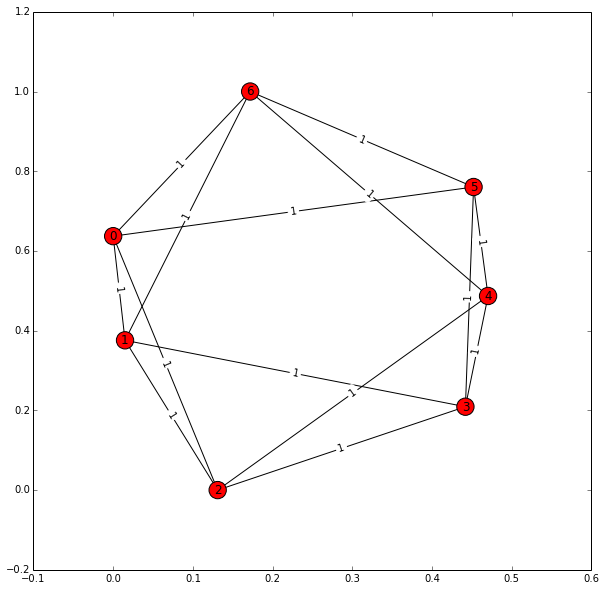

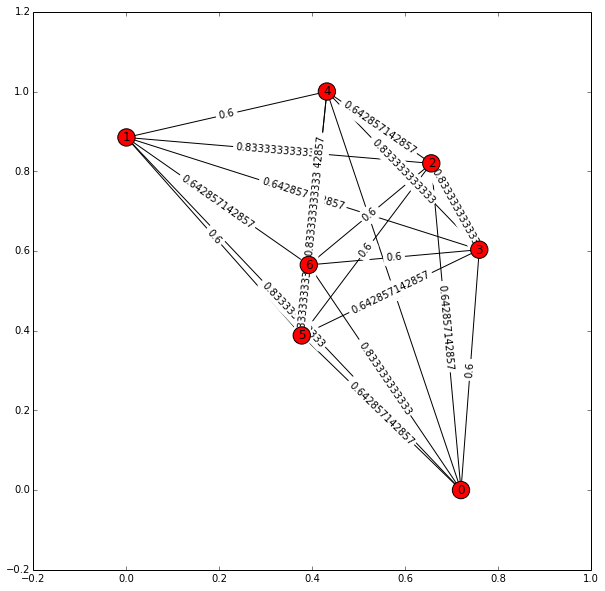

In [221]:
S0 = greedy_expected_max_coverage_set(WS1,2,1)
print "Two node soln to watts strogatz contact greedy",S0

S1 = greedy_expected_max_coverage_set(WS1,2,2)
print "Two node soln to watts strogatz contact opt",S1

S2 = greedy_expected_max_coverage_set(WS1_AWARENESS,2,1)
print "Two node soln to WS awareness greedy",S2

S3 = greedy_expected_max_coverage_set(WS1_AWARENESS,2,2)
print "Two node soln to WS awareness opt",S3

draw_graph_helper(WS1,"spring")

draw_graph_helper(WS1_AWARENESS,"spring")



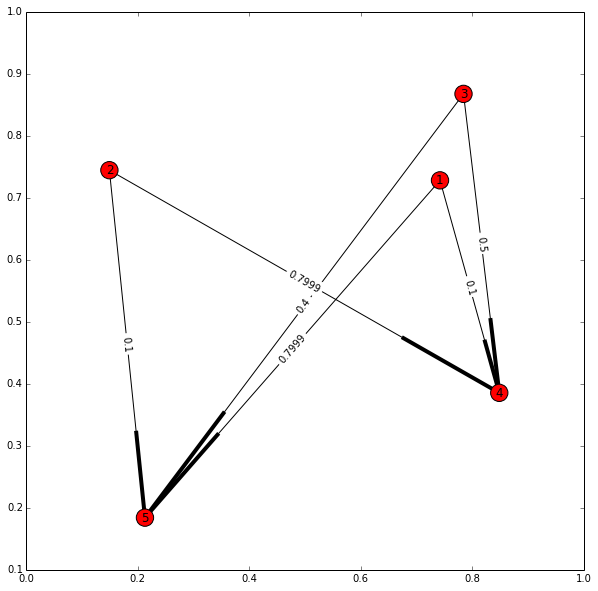

Expected coverage toy example, opt

 Selecting next  2 nodes from set  set([1, 2, 3, 4, 5])
Coverage of  set([1, 2]) is  1.63982
Using  (1, 2) as current best
Coverage of  set([1, 3]) is  1.42994
Coverage of  set([1, 4]) is  0.7999
Coverage of  set([1, 5]) is  0.1
Coverage of  set([2, 3]) is  1.35995
Coverage of  set([2, 4]) is  0.1
Coverage of  set([2, 5]) is  0.7999
Coverage of  set([3, 4]) is  0.4
Coverage of  set([3, 5]) is  0.5
Coverage of  set([4, 5]) is  0
Chose node(s)  [1, 2]
set([1, 2])
**

Expected coverage toy example, greedy (will choose non-opt due to non-robustness to small differences)

 Selecting next  1 nodes from set  set([1, 2, 3, 4, 5])
Coverage of  set([1]) is  0.8999
Using  (1,) as current best
Coverage of  set([2]) is  0.8999
Coverage of  set([3]) is  0.9
Using  (3,) as current best
Coverage of  set([4]) is  0
Coverage of  set([5]) is  0
Chose node(s)  [3]

 Selecting next  1 nodes from set  set([1, 2, 4, 5])
Coverage of  set([1, 3]) is  1.42994
Using  (1,) as c

In [223]:
#another sanity test

G = nx.DiGraph()
G.add_edge(1,4,weight=.1)
G.add_edge(1,5,weight=.7999)
G.add_edge(2,4,weight=.7999)
G.add_edge(2,5,weight=.1)
G.add_edge(3,4,weight=.5)
G.add_edge(3,5,weight=.4)

draw_graph_helper(G,"random")

print "Expected coverage toy example, opt"
print greedy_expected_max_coverage_set(G,2,2)

print "**\n\nExpected coverage toy example, greedy (will choose non-opt due to non-robustness to small differences)"
print greedy_expected_max_coverage_set(G,2,1)


In [ ]:
#Given a contact graph G and a committee, form the clique subgraph of the committee and perform tr 
def simple_committee_closure_augmentation